# Rabbits and foxes

There are initially 400 rabbits and 200 foxes on a farm (but it could be two cell types in a 96 well plate or something, if you prefer bio-engineering analogies). Plot the concentration of foxes and rabbits as a function of time for a period of up to 600 days. The predator-prey relationships are given by the following set of coupled ordinary differential equations:

\begin{align}
\frac{dR}{dt} &= k_1 R - k_2 R F \tag{1}\\
\frac{dF}{dt} &= k_3 R F - k_4 F \tag{2}\\
\end{align}

* Constant for growth of rabbits $k_1 = 0.015$ day<sup>-1</sup>
* Constant for death of rabbits being eaten by foxes $k_2 = 0.00004$ day<sup>-1</sup> foxes<sup>-1</sup>
* Constant for growth of foxes after eating rabbits $k_3 = 0.0004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* Constant for death of foxes $k_4 = 0.04$ day<sup>-1</sup>

*This problem is based on one from Chapter 1 of H. Scott Fogler's textbook "Essentials of Chemical Reaction Engineering".*


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from statistics import stdev

# Now let's try some Kinetic Monte Carlo

We wish to implement a Kinetic Monte Carlo algorithm to simulate the same situation. See https://en.wikipedia.org/wiki/Kinetic_Monte_Carlo for details.

We'll assume the numbers of rabbits and foxes (starting at 400 and 200) are actual rabbits and foxes, not "rabbit densities" for example, and so must always remain integers: you can't have half a rabbit or half a fox.

There are four events, with rates that are straightforward to calculate, so the rejection-free algorithm is suitable:
* `rabbit_birth = k1 * rabbits`
* `rabbit_death = k2 * rabbits * foxes`
* `fox_birth = k3 * rabbits * foxes`
* `fox_death = k4 * foxes`


Use a Kinetic Monte Carlo simulation(s) running for 600 days to determine
1. The expected location of the second peak in foxes (eg. 425 days, 2800 foxes), on occasions that there is one (eg. if there's a peak that's  >200 days and >100 foxes)
2. The interquartile range of the second peak in foxes (eg. 411-443 days, 2700-3120 foxes).
3. The probability that the foxes die out before 600 days are complete

Make sure you've done enough simulations to be suitably confident in your answers (given the precision you think appropriate).

# Your turn!

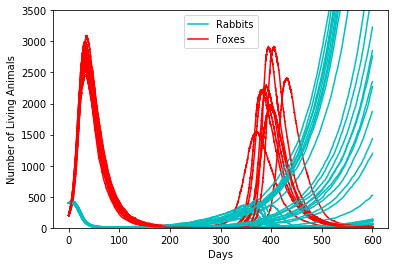

The foxes went extinct 150 times out of 200 or 75.0%.
The average second fox peak occurred at 407.6 days, with an average maximum of 2448 foxes.
The standard deviation of the days is 36.99, and the IQR is [384.8-421.8].
The standard deviation of the foxes is 611.84, and the IQR is [1974.2-2857.2].


In [2]:
import random
random.seed(1)
k1= 0.015
k2= 0.00004
k3= 0.0004
k4= 0.04
end_time= 600
iterations=200

#fn to calculate rates. r and f will be the current rabbit and fox populations
def rates(r, f):
    rabbit_birth= k1*r
    rabbit_death= k2*r*f
    fox_birth= k3*r*f
    fox_death= k4*f
    current_rates= (rabbit_birth, rabbit_death, fox_birth, fox_death)
    return current_rates

#created variables to count how many times fox population=0, second peak location arrays
extinct=0
second_peak_foxes= []
second_peak_t= []

#loop to iterate through the chosen number of iterations
for i in range(iterations):
    #created lists, filled with initial values. j is the index for the lists, looped in the while fn
    t= []
    foxes= []
    rabbits= []
    t.append(0)
    foxes.append(200)
    rabbits.append(400)
    r=400
    f=200
    j=0
    
    #loop kmc to determine the event (rabbit birth, fox death, etc) for each time in t
    while max(t)< end_time:
        (rabbit_birth, rabbit_death, fox_birth, fox_death)= current_rates= rates(r, f)
        sum_rates= sum(current_rates)
        if sum_rates== 0:
            #no rabbits or foxes left
            extinct+=1
            break
        #get change in time
        delta_t= random.expovariate(sum_rates)
        t.append(t[j]+ delta_t)
        event= random.uniform(0, sum_rates)
        #assign ranges for each event
        rdmax= rabbit_birth+ rabbit_death
        fbmax= rdmax+ fox_birth
        if event<rabbit_birth:
            #rabbit born
            rabbits.append(rabbits[j]+ 1)
            r+=1
            foxes.append(foxes[j])
        else:
            if rabbit_birth< event< rdmax:
                #rabbit dies
                rabbits.append(rabbits[j]- 1)
                r-=1
                foxes.append(foxes[j])
            else:
                if rdmax< event< fbmax:
                    #fox born
                    rabbits.append(rabbits[j])
                    foxes.append(foxes[j]+ 1)
                    f+=1
                else:
                    if fbmax< event< sum_rates:
                        #fox dies
                        rabbits.append(rabbits[j])
                        foxes.append(foxes[j]- 1)
                        f-=1
                        if f==0:
                            #no foxes left
                            extinct+=1
        #increase index counter for t, rabbits, and foxes
        j= j+ 1
        
    #format arrays
    t= np.array(t)
    rabbits= np.array(rabbits)
    foxes= np.array(foxes)
    
    #only the first 30 iterations are plotted so the graph is somewhat neat
    if i< 30:
        plt.plot(t, rabbits, 'c')
        plt.plot(t, foxes, 'r')
    
    #k is the index value of the peak
    k= np.argmax(foxes* (t> 200)* (foxes> 100))
    if k>0:
        second_peak_t.append(t[k])
        second_peak_foxes.append(foxes[k])
    
plt.legend(['Rabbits','Foxes'],loc="best")
plt.ylim(0,3500)
plt.xlabel('Days')
plt.ylabel('Number of Living Animals')
plt.show()

print("The foxes went extinct {} times out of {} or {:.1f}%.".format(extinct, iterations, 100*extinct/iterations))

#average values of time and foxes for the second fox peak, with standard deviation
avg_t= np.mean(second_peak_t)
avg_foxes= np.mean(second_peak_foxes)
stdevt= stdev(second_peak_t)
stdevf= stdev(second_peak_foxes)

print("The average second fox peak occurred at {:.1f} days, with an average maximum of {:.0f} foxes.".format(avg_t, avg_foxes))

#the interquartile range, or the middle 50% spread of the data
upperquartile_t= np.percentile(second_peak_t, 75)
lowerquartile_t= np.percentile(second_peak_t, 25)
upperquartile_foxes= np.percentile(second_peak_foxes, 75)
lowerquartile_foxes= np.percentile(second_peak_foxes, 25)

print("The standard deviation of the days is {:.2f}, and the IQR is [{:.1f}-{:.1f}].".format(stdevt, lowerquartile_t, upperquartile_t))
print("The standard deviation of the foxes is {:.2f}, and the IQR is [{:.1f}-{:.1f}].".format(stdevf, lowerquartile_foxes, upperquartile_foxes))

351